### Setup & Image

In [1]:
!pip install -U torch==1.5 torchvision==0.6 -f https://download.pytorch.org/whl/cu101/torch_stable.html
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
!pip install detectron2==0.1.3 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html

Looking in links: https://download.pytorch.org/whl/cu101/torch_stable.html
Requirement already up-to-date: torch==1.5 in /usr/local/lib/python3.6/dist-packages (1.5.0+cu101)
Requirement already up-to-date: torchvision==0.6 in /usr/local/lib/python3.6/dist-packages (0.6.0+cu101)
     |████████████████████████████████| 276kB 2.8MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp36-cp36m-linux_x86_64.whl size=44074 sha256=5fe03a72b59ca7b13b2b99ab3d66357c598b4cbe9abae7439dbf686f8ef1f78e
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-diro89eb
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-diro89eb
  Created wheel for pycocotools: filename=pycocotools-2.0-cp36-cp36m-lin

In [2]:
# libraries
import cv2
import random
import numpy as np
from google.colab.patches import cv2_imshow

import detectron2
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.data import MetadataCatalog
from detectron2.engine import DefaultPredictor
from detectron2.utils.logger import setup_logger
from detectron2.utils.visualizer import Visualizer
setup_logger()

<Logger detectron2 (DEBUG)>

In [3]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)

model_final_a6e10b.pkl: 237MB [00:22, 10.4MB/s]                           


In [0]:
def instantiate_image_from_url(img_url, orientation='ver'):
  '''
  Shows input image and instantiated image for pose detection concateneted.
    
    Parameters:
      img_url                (str): url of the input image
      orientation (optional) (str): 'ver' for vertical, 'hor' for horizontal 
    
    Returns:
      outputs: output from predictor
  '''

  import urllib.request
  urllib.request.urlretrieve(img_url, "input.jpg")
  in_im = cv2.imread("./input.jpg")

  outputs = predictor(in_im)
  v = Visualizer(in_im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]))
  v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
  out_im = v.get_image()[:, :, ::-1]

  if orientation == 'ver':
    final_frame = cv2.vconcat((in_im, out_im))
  elif orientation == 'hor':
    final_frame = cv2.hconcat((in_im, out_im))
  cv2_imshow(final_frame)
  
  return outputs

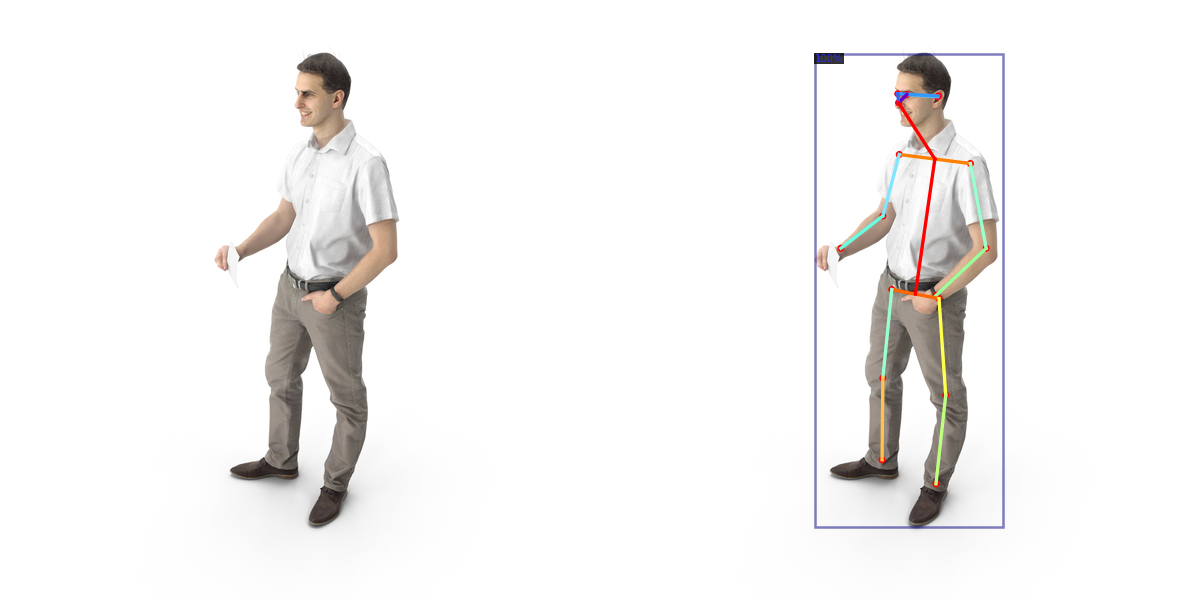

In [5]:
out = instantiate_image_from_url('https://atlas-content-cdn.pixelsquid.com/stock-images/man-standing-with-note-5ANnkr1-600.jpg', 'hor')

### Video

In [0]:
!mkdir in_video
!mkdir in_frames
!mkdir out_frames
!mkdir out_video

In [0]:
!wget -q https://gdurl.com/d8Zp/download
!mv download taiji.mp4
!mv taiji.mp4 in_video/taiji.mp4

In [9]:
import cv2
vidcap = cv2.VideoCapture('in_video/taiji.mp4')
success, image = vidcap.read()
count = 1
prefix = '000'
while success:
  if count == 10: prefix = '00'
  elif count == 100: prefix = '0'
  cv2.imwrite(f"in_frames/frame{prefix+str(count)}.jpg", image)
  success, image = vidcap.read()
  count += 1
print('Total Frames:', count)

Total Frames: 956


In [0]:
def instantiate_image_from_directory(directory):
  '''
  Shows input image and instantiated image for pose detection concateneted.
    
    Parameters:
      img_url                (str): url of the input image
      orientation (optional) (str): 'ver' for vertical, 'hor' for horizontal 
    
    Returns:
      outputs: output from predictor
  '''
  # print('>'+directory.split('/')[-1])
  in_im = cv2.imread(directory)

  outputs = predictor(in_im)
  v = Visualizer(in_im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]))
  v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
  out_im = v.get_image()[:, :, ::-1]
  cv2.imwrite('out_frames/'+directory.split('/')[-1], out_im)

  return outputs

In [0]:
import os
_in_img = os.listdir('in_frames')
_in_img = ['in_frames/' + i for i in _in_img]
_in_img = sorted(_in_img)

In [0]:
for i in range(len(_in_img)):
  out_co = instantiate_image_from_directory(_in_img[i])

In [0]:
import os
_out_img = os.listdir('out_frames')
_out_img = ['out_frames/' + i for i in _out_img]
_out_img = sorted(_out_img)

In [0]:
import cv2
import numpy as np
import glob

img_array = []
flag = False
for filename in _out_img:
  img = cv2.imread(filename)
  if flag == False:
    height, width, layers = img.shape
    size = (width, height)
    flag = True
  img_array.append(img)

out = cv2.VideoWriter('out_video/output.avi', cv2.VideoWriter_fourcc(*'DIVX'), 31, size)
 
for i in range(len(img_array)):
  out.write(img_array[i])
out.release()

    Things to improve:
      - fps calculation, same for in & out video.
      - size of the out_video, play with formats.